In [32]:
import pandas as pd
from influxdb_client import InfluxDBClient, Point, WriteOptions 
from influxdb_client.client.write_api import SYNCHRONOUS
import time

# Параметры для подключения к InfluxDB
bucket = "eee"
org = "AKULA1"
token = "XDBtANrCelRK0vXOYd0yTkMDF2YPZsM_i2Y88ZUmSWIZXMTkoDRtYCMgfAb3D6icLsVegYVeVCwhNYGmnQdQvg=="
url = "http://localhost:8086"

# Read the CSV file into a DataFrame
df = pd.read_csv('filtered_df.csv')

# Преобразуем столбец 'timestamp' в формат datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])


# Создаем клиент для подключения к InfluxDB
client = InfluxDBClient(url=url, token=token, org=org)

# Создаем API для записи данных с заданными параметрами
write_api = client.write_api(write_options=WriteOptions(batch_size=500, flush_interval=1000))

# Проходим по каждой строке DataFrame
for index, row in df.iterrows():
    try:
        # Создаем точку данных для записи в InfluxDB
        point = (
            Point("sensors_data")  # Указываем название измерения
            .tag("Temperature", row['sensortype']) # Задаем тег с идентификатором типа сенсора
            .tag("sensorid", row['sensorid']) # Задаем тег с идентификатором типа сенсора
            .time(row['timestamp'])  # Указываем время события
            .field("Sensordata", row['sensordata'])  # Указываем значение сенсора
        )
        # print(row)
        # time.sleep(0.1)  # Задержка в 0.1 секунды между записями
        write_api.write(bucket=bucket, record=point)  # Записываем точку данных в указанный бакет

    except InfluxDBError as e:  # Обрабатываем ошибки при записи данных
        print(e)  # Выводим сообщение об ошибке

# Выводим сообщение об успешном завершении импорта данных
print("Data imported successfully!")

# Закрытие клиента
client.close()

Data imported successfully!


In [33]:
import pandas as pd
import influxdb_client
client = influxdb_client.InfluxDBClient(
    url=url,
    token=token,
    org=org
)
query_api = client.query_api()
# Составляем запрос на получение из БД
# значений сенсора с ID = 1, по всем
# имеющимся временным меткам
query = """from(bucket: "eee")
 |> range(start: 0 )
 |> filter(fn: (r) => r["_measurement"] == "sensors_data")
 |> filter(fn: (r) => r["sensorid"] == "10")
  """
tables = query_api.query(query, org="AKULA1")
# print(tables)
# При помощи цикла запишем возвращаемые строки
# в лист data
data = []
for table in tables:
  for record in table.records:
    # print(record)
    data.append({'timestamp': record.get_time(),
                 'value': record.get_value()})
client.close()
# Преобразуем лист в датафрейм
df = pd.DataFrame(data)
# На основе временных меток сформируем
# временные признаки
df['minute'] = df['timestamp'].dt.minute.astype('int64')
df['hour'] = df['timestamp'].dt.hour.astype('int64')
df['second'] = df['timestamp'].dt.second.astype('int64')
# На основе целевой колонки сформируем
# дополнитлеьный сдвиговый признак
df['shift_5'] = df['value'].shift(5)
df.index = pd.DatetimeIndex(df['timestamp'])
df = df.drop(['timestamp'], axis=1)
df.index.sort_values()
# df['value'].plot()

df = df.dropna()

In [35]:
df

,value,minute,hour,second,shift_5
timestamp,,,,,
2024-04-18 00:00:05+00:00,80.298698,0,0,5,21.799012
2024-04-18 00:00:06+00:00,66.404557,0,0,6,16.546189
2024-04-18 00:00:07+00:00,19.838376,0,0,7,3.998126
2024-04-18 00:00:08+00:00,40.502318,0,0,8,49.105791
2024-04-18 00:00:09+00:00,29.348776,0,0,9,42.702048
...,...,...,...,...,...
2024-04-18 00:01:35+00:00,76.953710,1,0,35,98.045212
2024-04-18 00:01:36+00:00,90.675148,1,0,36,70.220119
2024-04-18 00:01:37+00:00,1.172922,1,0,37,86.956022


In [36]:
# train_test_split - функция для разделения данных на тренировочный и тестовый
# наборы, используется для проверки моделей машинного обучения
# Импортируем функцию для разделения данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

# Импортируем библиотеку для построения графиков
import matplotlib.pyplot as plt

# Импортируем метрики для оценки качества модели
from sklearn.metrics import r2_score, mean_absolute_error

# Импортируем функцию для создания пайплайнов
from sklearn.pipeline import make_pipeline

# Импортируем регрессоры: стохастический градиентный спуск и многослойный перцептрон
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

# Импортируем библиотеку XGBoost для градиентного бустинга
import xgboost as xgb

# Импортируем стандартный скейлер для нормализации данных
from sklearn.preprocessing import StandardScaler

# Создаем экземпляр StandardScaler для масштабирования данных
scaler = StandardScaler()

def train_test_split_fnc(data, aim_col, train_size=0.001, test_size=0.41, shuffle=True):

    X, y = data.drop([aim_col], axis=1), data[aim_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, shuffle=shuffle)

    return X_train, X_test, y_train, y_test

def count_metrics(y_train, y_pred):

    mae = mean_absolute_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    print(f"MAE: {mae}, r2: {r2}")

    return mae, r2


In [37]:
aim_col = 'value'
X_train, X_test, y_train, y_test = train_test_split_fnc(df, aim_col, train_size=0.95, test_size=0.05, shuffle=False)

In [38]:
# Создаем пайплайн, который сначала стандартизирует данные, а затем обучает регрессионную модель
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000))

# Обучаем модель на обучающей выборке (X_train и y_train)
sgd = reg.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки (X_test) с помощью обученной модели
y_regr_pred = sgd.predict(X_test)

# Вызываем функцию для оценки качества модели, передавая истинные значения y_test и предсказанные y_regr_pred
count_metrics(y_test, y_regr_pred)


MAE: 36.78156653598667, r2: -0.16520720573127545


(np.float64(36.78156653598667), -0.16520720573127545)

In [39]:
mlp = make_pipeline(StandardScaler(),
                    MLPRegressor(hidden_layer_sizes=(150, 100, 150), max_iter=100))
mlp.fit(X_train, y_train)
y_reg_mlp_pred = mlp.predict(X_test)
count_metrics(y_test, y_reg_mlp_pred)

MAE: 35.5068568516327, r2: -0.14898537942590595


(np.float64(35.5068568516327), -0.14898537942590595)

In [40]:
xgb_reg = make_pipeline(StandardScaler(), xgb.XGBRFRegressor())
# xgb_reg = xgb.XGBRFRegressor()
xgb_reg.fit(X_train, y_train)
y_xgb_pred = xgb_reg.predict(X_test)
count_metrics(y_test, y_xgb_pred)

MAE: 31.540203959071796, r2: -0.19847160962457933


(np.float64(31.540203959071796), -0.19847160962457933)

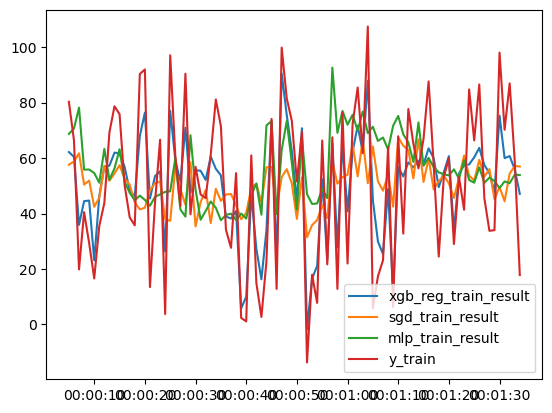

In [41]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt

# Строим график результата обучения различных моделей
plt.plot(y_train.index, xgb_reg.predict(X_train), label='xgb_reg_train_result')    # Прогноз модели XGBoost
plt.plot(y_train.index, sgd.predict(X_train), label='sgd_train_result')            # Прогноз модели SGDRegressor
plt.plot(y_train.index, mlp.predict(X_train), label='mlp_train_result')            # Прогноз модели MLP (Multi-Layer Perceptron)
plt.plot(y_train.index, y_train, label='y_train')                                  # Истинные значения y_train

# Добавляем легенду для различения линий на графике
plt.legend()

# Отображаем график
plt.show()


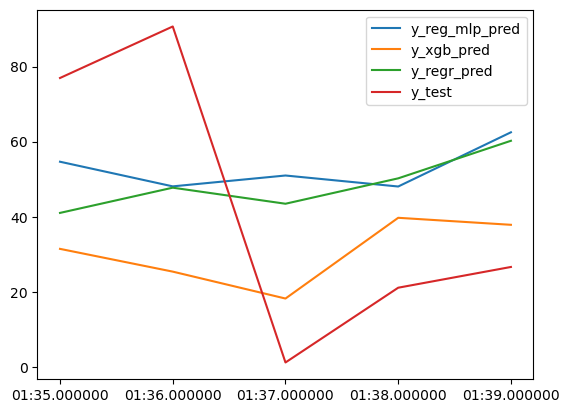

In [42]:
# Строим график для прогноза различных моделей на тестовой выборке
plt.plot(y_test.index, y_reg_mlp_pred, label='y_reg_mlp_pred')    # Прогноз модели MLP на тестовой выборке
plt.plot(y_test.index, y_xgb_pred, label='y_xgb_pred')            # Прогноз модели XGBoost на тестовой выборке
plt.plot(y_test.index, y_regr_pred, label='y_regr_pred')          # Прогноз модели SGDRegressor на тестовой выборке
plt.plot(y_test.index, y_test, label='y_test')                    # Истинные значения y_test

# Добавляем легенду для различения линий на графике
plt.legend()

# Отображаем график
plt.show()


MAE: 36.805871293260054, R²: -0.1667362773573997
MAE: 35.619144343029745, R²: -0.15802209628788644
MAE: 31.540203959071796, R²: -0.19847160962457933


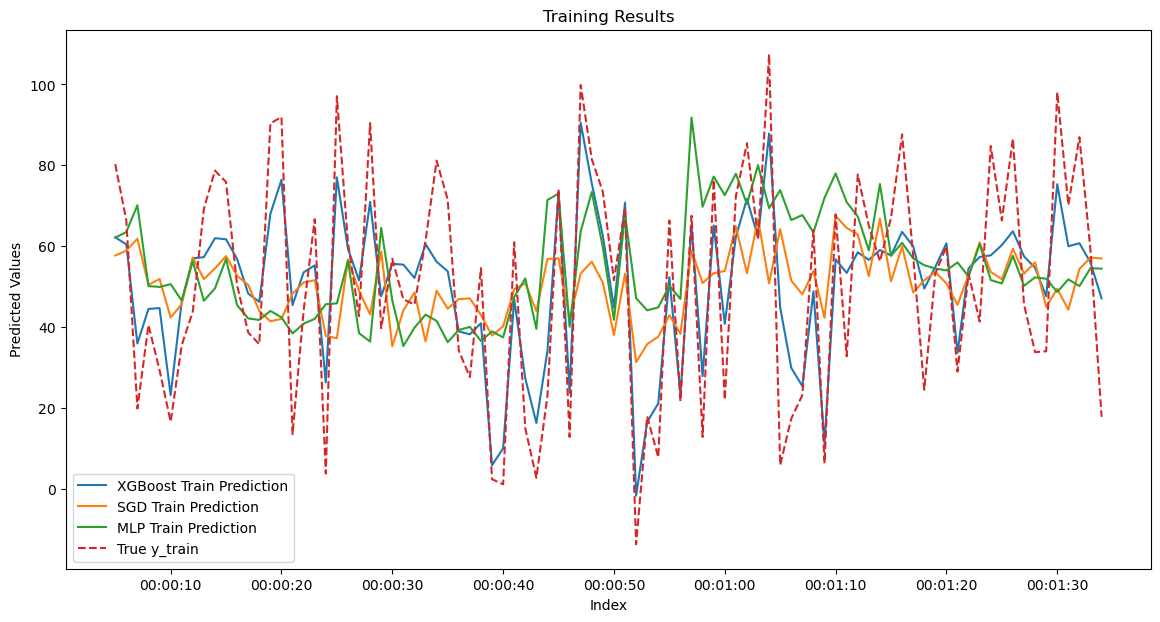

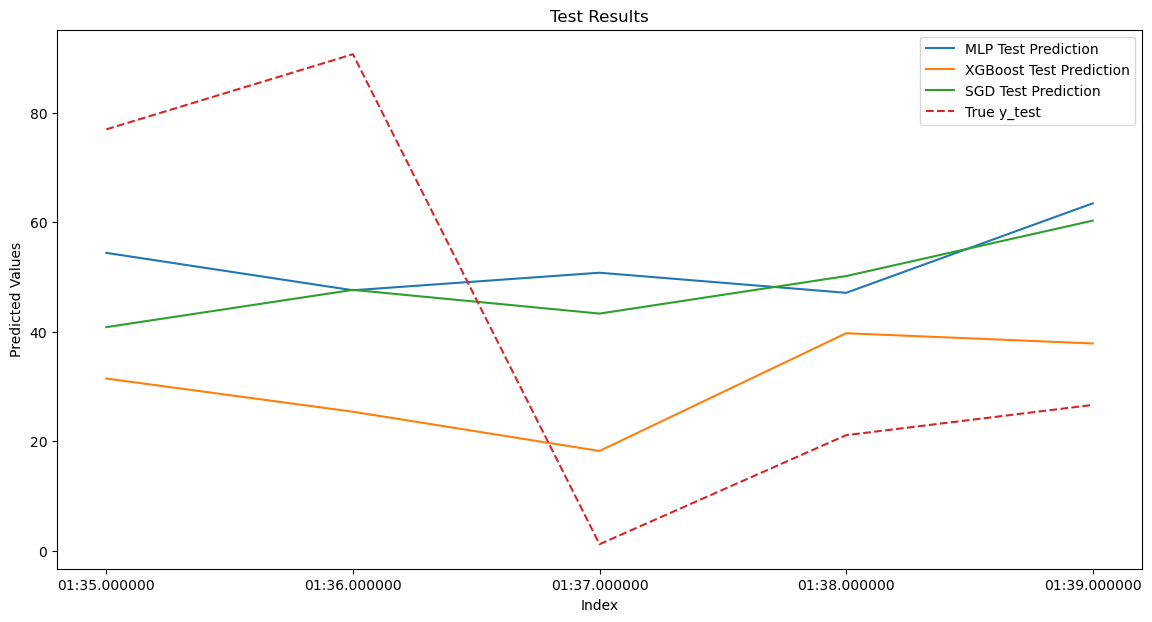

  Model        MAE        R²
0   sgd  36.805871 -0.166736
1   mlp  35.619144 -0.158022
2   xgb  31.540204 -0.198472
         sgd        mlp        xgb                 timestamp
0  40.826220  54.389859  31.437105 2024-04-18 00:01:35+00:00
1  47.628987  47.559449  25.374424 2024-04-18 00:01:36+00:00
2  43.302929  50.763711  18.205040 2024-04-18 00:01:37+00:00
3  50.151092  47.094691  39.712559 2024-04-18 00:01:38+00:00
4  60.280258  63.436343  37.844666 2024-04-18 00:01:39+00:00


In [43]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Создаем экземпляр StandardScaler для масштабирования данных
scaler = StandardScaler()

def train_test_split_fnc(data, aim_col, train_size=0.001, test_size=0.41, shuffle=True):
    X, y = data.drop([aim_col], axis=1), data[aim_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, shuffle=shuffle)
    return X_train, X_test, y_train, y_test

def count_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae}, R²: {r2}")
    return mae, r2

# Предположим, что у вас есть DataFrame df и целевая колонка 'value'
aim_col = 'value'
X_train, X_test, y_train, y_test = train_test_split_fnc(df, aim_col, train_size=0.95, test_size=0.05, shuffle=False)

# Создаем и обучаем модели
sgd = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000))
sgd.fit(X_train, y_train)
y_regr_pred = sgd.predict(X_test)
sgd_metrics = count_metrics(y_test, y_regr_pred)

mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(150, 100, 150), max_iter=100))
mlp.fit(X_train, y_train)
y_reg_mlp_pred = mlp.predict(X_test)
mlp_metrics = count_metrics(y_test, y_reg_mlp_pred)

xgb_reg = make_pipeline(StandardScaler(), xgb.XGBRFRegressor())
xgb_reg.fit(X_train, y_train)
y_xgb_pred = xgb_reg.predict(X_test)
xgb_metrics = count_metrics(y_test, y_xgb_pred)

# Строим график результата обучения различных моделей
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, xgb_reg.predict(X_train), label='XGBoost Train Prediction')
plt.plot(y_train.index, sgd.predict(X_train), label='SGD Train Prediction')
plt.plot(y_train.index, mlp.predict(X_train), label='MLP Train Prediction')
plt.plot(y_train.index, y_train, label='True y_train', linestyle='--')
plt.legend()
plt.title('Training Results')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.show()

# Строим график для прогноза различных моделей на тестовой выборке
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_reg_mlp_pred, label='MLP Test Prediction')
plt.plot(y_test.index, y_xgb_pred, label='XGBoost Test Prediction')
plt.plot(y_test.index, y_regr_pred, label='SGD Test Prediction')
plt.plot(y_test.index, y_test, label='True y_test', linestyle='--')
plt.legend()
plt.title('Test Results')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.show()

# Создаем датафрейм с метриками
metrics = {
    'Model': ['sgd', 'mlp', 'xgb'],
    'MAE': [sgd_metrics[0], mlp_metrics[0], xgb_metrics[0]],
    'R²': [sgd_metrics[1], mlp_metrics[1], xgb_metrics[1]]
}
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

# Создаем датафрейм с прогнозами
predictions = {
    'sgd': y_regr_pred,
    'mlp': y_reg_mlp_pred,
    'xgb': y_xgb_pred,
    'timestamp': y_test.index
}
df_predictions = pd.DataFrame(predictions)
print(df_predictions)


In [19]:
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

# Устанавливаем целевую модель для записи
aim_model = 'sgd'

# Создаем клиент для подключения к InfluxDB
client = InfluxDBClient(url=url, token=token, org=org)

# Получаем API для записи данных
write_api = client.write_api(write_options=SYNCHRONOUS)

# Проходим по каждой строке в DataFrame с предсказаниями
for index, row in df_predictions.iterrows():
    try:
        mae_value = df_metrics.loc[df_metrics['Model'] == aim_model, 'mae'].values[0]
        r2_value = df_metrics.loc[df_metrics['Model'] == aim_model, 'r2'].values[0]
        
        point = (
            Point("sensors_data_prediction")
            .tag("mae", str(mae_value))
            .tag("r2", str(r2_value))
            .tag("SensorID", "10")
            .tag("DataType", 'prediction')
            .time(row['timestamp'], WritePrecision.NS)
            .field(aim_model, row[aim_model])
        )
        write_api.write(bucket='ebu', record=point)
    
    except Exception as e:
        # Если произошла ошибка, выводим её
        print(e)

print("Data imported successfully!")

# Закрываем соединение с клиентом
client.close()


'mae'
'mae'
'mae'
'mae'
'mae'
Data imported successfully!


In [46]:
print(df_metrics)
print("---")
print(df_predictions)

  Model        MAE        R²
0   sgd  36.805871 -0.166736
1   mlp  35.619144 -0.158022
2   xgb  31.540204 -0.198472
---
         sgd        mlp        xgb                 timestamp
0  40.826220  54.389859  31.437105 2024-04-18 00:01:35+00:00
1  47.628987  47.559449  25.374424 2024-04-18 00:01:36+00:00
2  43.302929  50.763711  18.205040 2024-04-18 00:01:37+00:00
3  50.151092  47.094691  39.712559 2024-04-18 00:01:38+00:00
4  60.280258  63.436343  37.844666 2024-04-18 00:01:39+00:00


In [48]:
# Параметры для подключения к InfluxDB
bucket = "eee"
org = "AKULA1"
token = "XDBtANrCelRK0vXOYd0yTkMDF2YPZsM_i2Y88ZUmSWIZXMTkoDRtYCMgfAb3D6icLsVegYVeVCwhNYGmnQdQvg=="
url = "http://localhost:8086"


# Set the target model for writing to InfluxDB
aim_model = 'sgd'


# Создаем клиент для подключения к InfluxDB
client = InfluxDBClient(url=url, token=token, org=org)

# Получаем API для записи данных
# write_api = client.write_api()

# Создаем API для записи данных с заданными параметрами
write_api = client.write_api(write_options=WriteOptions(batch_size=500, flush_interval=1000))


# Check if df_predictions is not empty
if df_predictions.empty:
    print("df_predictions is empty. No data to write to InfluxDB.")
else:
    # Get the metrics for the aim_model
    mae_value = df_metrics.loc[df_metrics['Model'] == aim_model, 'MAE'].values[0]
    r2_value = df_metrics.loc[df_metrics['Model'] == aim_model, 'R²'].values[0]

    # Write predictions to InfluxDB
    for index, row in df_predictions.iterrows():
        try:
            point = (
                Point("sensors_data_prediction")
                .tag('mae', mae_value)
                .tag('r2', r2_value)
                .tag("SensorID", 10)
                .tag("DataType", 'prediction')
                .time(row['timestamp'])
                .field(aim_model, row[aim_model])
            )
            print(mae_value)
            print(r2_value)
            print("10")
            print("prediction")
            print(row['timestamp'])
            print(aim_model, row[aim_model])
            write_api.write(bucket=bucket, record=point)  # Записываем точку данных в указанный бакет
            print(f"Data point for index {index} written successfully.")
        except Exception as e:
            print(f"Error writing to InfluxDB for index {index}: {e}")

print("Data import process completed.")
client.close()


36.805871293260054
-0.1667362773573997
10
prediction
2024-04-18 00:01:35+00:00
sgd 40.82622027611686
Data point for index 0 written successfully.
36.805871293260054
-0.1667362773573997
10
prediction
2024-04-18 00:01:36+00:00
sgd 47.62898681702889
Data point for index 1 written successfully.
36.805871293260054
-0.1667362773573997
10
prediction
2024-04-18 00:01:37+00:00
sgd 43.3029285757305
Data point for index 2 written successfully.
36.805871293260054
-0.1667362773573997
10
prediction
2024-04-18 00:01:38+00:00
sgd 50.151092350941276
Data point for index 3 written successfully.
36.805871293260054
-0.1667362773573997
10
prediction
2024-04-18 00:01:39+00:00
sgd 60.28025792957836
Data point for index 4 written successfully.
Data import process completed.


MAE: 36.788588316971136, R²: -0.1658958706143845
MAE: 35.68479127237963, R²: -0.20084908787838174
MAE: 31.540203959071796, R²: -0.19847160962457933


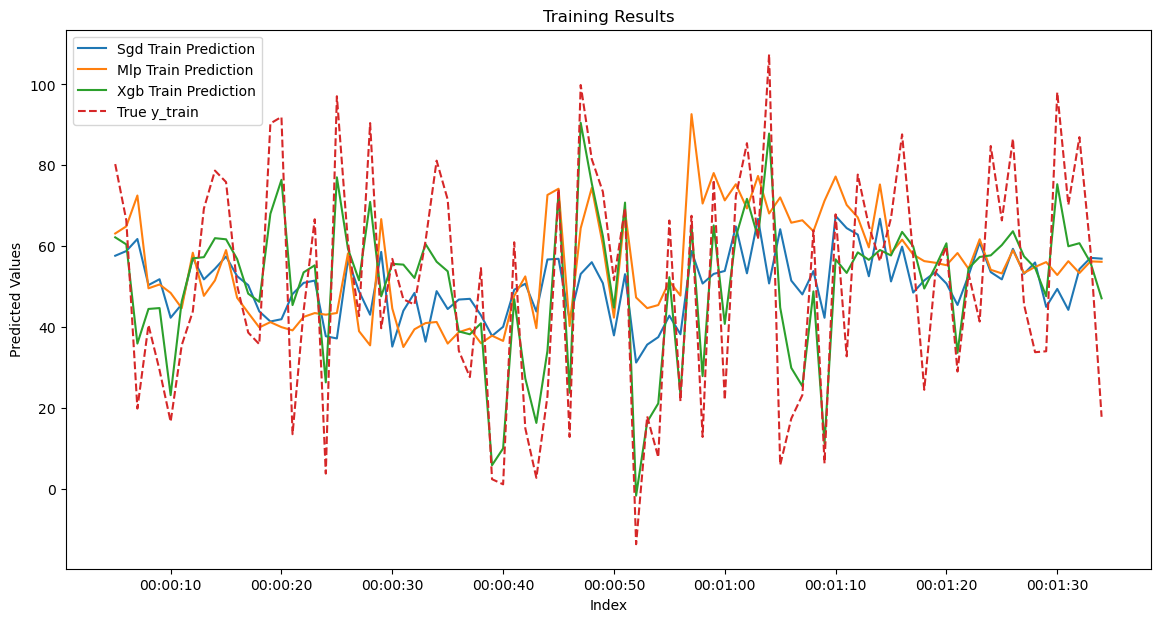

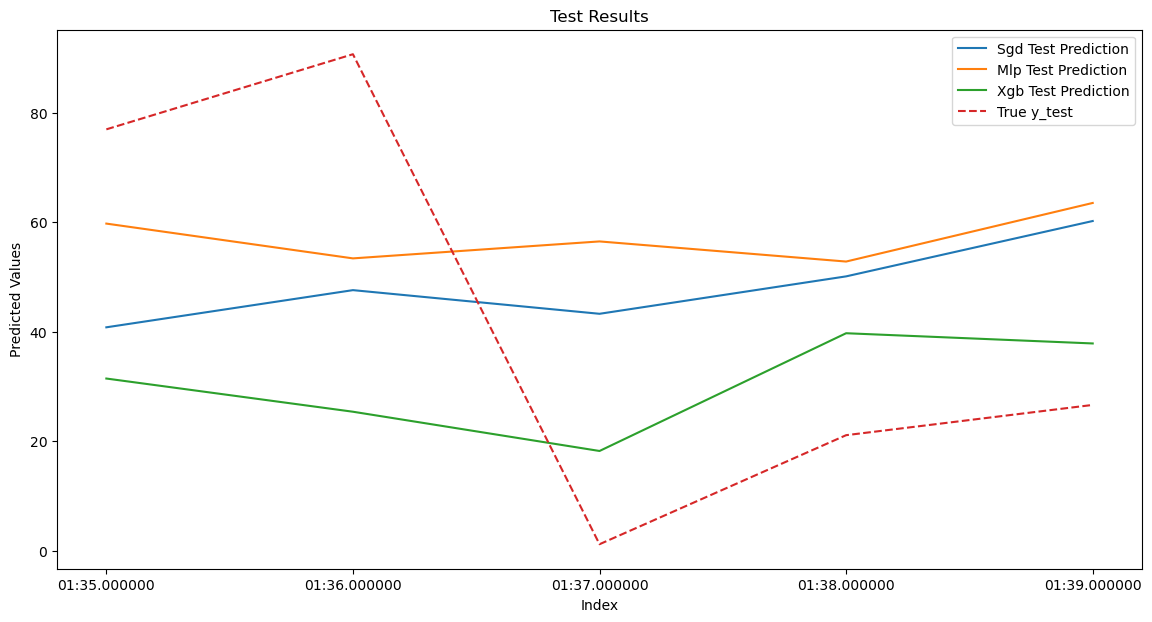

  Model        MAE        R²
0   sgd  36.788588 -0.165896
1   mlp  35.684791 -0.200849
2   xgb  31.540204 -0.198472
         sgd        mlp        xgb                 timestamp
0  40.793350  59.738247  31.437105 2024-04-18 00:01:35+00:00
1  47.583271  53.383790  25.374424 2024-04-18 00:01:36+00:00
2  43.262645  56.481407  18.205040 2024-04-18 00:01:37+00:00
3  50.097888  52.805910  39.712559 2024-04-18 00:01:38+00:00
4  60.208745  63.508391  37.844666 2024-04-18 00:01:39+00:00
Data point for index 0 written successfully.
Data point for index 1 written successfully.
Data point for index 2 written successfully.
Data point for index 3 written successfully.
Data point for index 4 written successfully.
Data import process completed.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS

# Initialize StandardScaler
scaler = StandardScaler()

def train_test_split_fnc(data, aim_col, train_size=0.001, test_size=0.41, shuffle=True):
    """Split data into training and testing sets."""
    X, y = data.drop([aim_col], axis=1), data[aim_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, shuffle=shuffle)
    return X_train, X_test, y_train, y_test

def count_metrics(y_true, y_pred):
    """Calculate and print MAE and R² metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae}, R²: {r2}")
    return mae, r2

# Assuming df is your DataFrame and 'value' is the target column
aim_col = 'value'
X_train, X_test, y_train, y_test = train_test_split_fnc(df, aim_col, train_size=0.95, test_size=0.05, shuffle=False)

# Train and evaluate models
models = {
    'sgd': make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000)),
    'mlp': make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(150, 100, 150), max_iter=100)),
    'xgb': make_pipeline(StandardScaler(), xgb.XGBRFRegressor())
}

predictions = {}
metrics = {'Model': [], 'MAE': [], 'R²': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred
    mae, r2 = count_metrics(y_test, y_pred)
    metrics['Model'].append(model_name)
    metrics['MAE'].append(mae)
    metrics['R²'].append(r2)

# Plot training results
plt.figure(figsize=(14, 7))
for model_name, model in models.items():
    plt.plot(y_train.index, model.predict(X_train), label=f'{model_name.capitalize()} Train Prediction')
plt.plot(y_train.index, y_train, label='True y_train', linestyle='--')
plt.legend()
plt.title('Training Results')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.show()

# Plot test results
plt.figure(figsize=(14, 7))
for model_name in predictions:
    plt.plot(y_test.index, predictions[model_name], label=f'{model_name.capitalize()} Test Prediction')
plt.plot(y_test.index, y_test, label='True y_test', linestyle='--')
plt.legend()
plt.title('Test Results')
plt.xlabel('Index')
plt.ylabel('Predicted Values')
plt.show()

# Create DataFrames for metrics and predictions
df_metrics = pd.DataFrame(metrics)
df_predictions = pd.DataFrame({**predictions, 'timestamp': y_test.index})

print(df_metrics)
print(df_predictions)

# Параметры для подключения к InfluxDB
bucket = "eee"
org = "AKULA1"
token = "XDBtANrCelRK0vXOYd0yTkMDF2YPZsM_i2Y88ZUmSWIZXMTkoDRtYCMgfAb3D6icLsVegYVeVCwhNYGmnQdQvg=="
url = "http://localhost:8086"


# Set the target model for writing to InfluxDB
aim_model = 'sgd'


# Создаем клиент для подключения к InfluxDB
client = InfluxDBClient(url=url, token=token, org=org)

# Получаем API для записи данных
# write_api = client.write_api()

# Создаем API для записи данных с заданными параметрами
write_api = client.write_api(write_options=WriteOptions(batch_size=500, flush_interval=1000))

# Check if df_predictions is not empty
if df_predictions.empty:
    print("df_predictions is empty. No data to write to InfluxDB.")
else:

    
    # Write predictions to InfluxDB
    for index, row in df_predictions.iterrows():
        try:
            point = (
                Point("sensors_data_prediction")
                .tag('mae', df_metrics.loc[df_metrics['Model'] == aim_model, 'MAE'].values[0])
                .tag('r2', df_metrics.loc[df_metrics['Model'] == aim_model, 'R²'].values[0])
                .tag("SensorID", 10)
                .tag("DataType", 'prediction')
                .time(row['timestamp'])
                .field(aim_model, row[aim_model])
            )
            write_api.write(bucket=bucket, record=point)  # Записываем точку данных в указанный бакет
            print(f"Data point for index {index} written successfully.")
        except Exception as e:
            print(f"Error writing to InfluxDB for index {index}: {e}")

print("Data import process completed.")
client.close()


In [30]:

# Параметры для подключения к InfluxDB
bucket = "ebu"
org = "AKULA1"
token = "XDBtANrCelRK0vXOYd0yTkMDF2YPZsM_i2Y88ZUmSWIZXMTkoDRtYCMgfAb3D6icLsVegYVeVCwhNYGmnQdQvg=="
url = "http://localhost:8086"


# Set the target model for writing to InfluxDB
aim_model = 'sgd'


# Создаем клиент для подключения к InfluxDB
client = InfluxDBClient(url=url, token=token, org=org)

# Получаем API для записи данных
# write_api = client.write_api()

# Создаем API для записи данных с заданными параметрами
write_api = client.write_api(write_options=WriteOptions(batch_size=500, flush_interval=1000))

# Check if df_predictions is not empty
if df_predictions.empty:
    print("df_predictions is empty. No data to write to InfluxDB.")
else:

    
    # Write predictions to InfluxDB
    for index, row in df_predictions.iterrows():
        try:
            point = (
                Point("sensors_data_prediction")
                .tag('mae', df_metrics.loc[df_metrics['Model'] == aim_model, 'MAE'].values[0])
                .tag('r2', df_metrics.loc[df_metrics['Model'] == aim_model, 'R²'].values[0])
                .tag("SensorID", 10)
                .tag("DataType", 'prediction')
                .time(row['timestamp'])
                .field(aim_model, row[aim_model])
            )
            write_api.write(bucket=bucket, record=point)  # Записываем точку данных в указанный бакет
            print(f"Data point for index {index} written successfully.")
        except Exception as e:
            print(f"Error writing to InfluxDB for index {index}: {e}")

print("Data import process completed.")
client.close()

Data point for index 0 written successfully.
Data point for index 1 written successfully.
Data point for index 2 written successfully.
Data point for index 3 written successfully.
Data point for index 4 written successfully.
Data import process completed.


Загрузка данных

In [44]:
import psycopg2
from psycopg2 import sql

# Data to be inserted
model_data = [
    ('sgd', 36.769157, -0.164834),
    ('mlp', 34.503524, -0.100193),
    ('xgb', 31.540204, -0.198472)
]

timestamped_data = [
    (40.844777, 54.899550, 31.437105, '2024-04-18 00:01:35+00:00'),
    (47.592910, 46.388163, 25.374424, '2024-04-18 00:01:36+00:00'),
    (43.299461, 50.273048, 18.205040, '2024-04-18 00:01:37+00:00'),
    (50.092635, 45.793925, 39.712559, '2024-04-18 00:01:38+00:00'),
    (60.141091, 58.988078, 37.844666, '2024-04-18 00:01:39+00:00')
]

# Connect to the database
conn = psycopg2.connect(
    database='edu-pgsql-stud-db',
    host='ep-withered-leaf-a2t7yple.eu-central-1.aws.neon.tech',
    user='student',
    password='strong_student_password'
)

cursor = conn.cursor()

# Define the schema and table names
schema_name = 'ist23'
model_table_name = 'verushkina_v_i_model_stats'
timestamped_table_name = 'verushkina_v_i_timestamped_stats'

# Create the model stats table if it does not exist
create_model_table_query = sql.SQL("""
    CREATE TABLE IF NOT EXISTS {}.{} (
        id SERIAL PRIMARY KEY,
        model VARCHAR(50),
        mae FLOAT,
        r2 FLOAT
    )
""").format(sql.Identifier(schema_name), sql.Identifier(model_table_name))

cursor.execute(create_model_table_query)
conn.commit()

# Create the timestamped stats table if it does not exist
create_timestamped_table_query = sql.SQL("""
    CREATE TABLE IF NOT EXISTS {}.{} (
        id SERIAL PRIMARY KEY,
        sgd FLOAT,
        mlp FLOAT,
        xgb FLOAT,
        timestamp TIMESTAMPTZ
    )
""").format(sql.Identifier(schema_name), sql.Identifier(timestamped_table_name))

cursor.execute(create_timestamped_table_query)
conn.commit()

# Insert model data into the model stats table
insert_model_query = sql.SQL("INSERT INTO {}.{} (model, mae, r2) VALUES (%s, %s, %s)").format(
    sql.Identifier(schema_name), sql.Identifier(model_table_name)
)

for row in model_data:
    cursor.execute(insert_model_query, row)

# Insert timestamped data into the timestamped stats table
insert_timestamped_query = sql.SQL("INSERT INTO {}.{} (sgd, mlp, xgb, timestamp) VALUES (%s, %s, %s, %s)").format(
    sql.Identifier(schema_name), sql.Identifier(timestamped_table_name)
)

for row in timestamped_data:
    cursor.execute(insert_timestamped_query, row)

# Commit the transaction
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

print("Data import process completed.")


Data import process completed.


In [45]:
import psycopg2
from psycopg2 import sql

# Connect to the database
conn = psycopg2.connect(
    database='edu-pgsql-stud-db',
    host='ep-withered-leaf-a2t7yple.eu-central-1.aws.neon.tech',
    user='student',
    password='strong_student_password'
)

cursor = conn.cursor()

# Define the schema and table names
schema_name = 'ist23'
model_table_name = 'verushkina_v_i_model_stats'
timestamped_table_name = 'verushkina_v_i_timestamped_stats'

# Query the model stats table
select_model_query = sql.SQL("SELECT * FROM {}.{}").format(
    sql.Identifier(schema_name), sql.Identifier(model_table_name)
)
cursor.execute(select_model_query)
model_rows = cursor.fetchall()

# Query the timestamped stats table
select_timestamped_query = sql.SQL("SELECT * FROM {}.{}").format(
    sql.Identifier(schema_name), sql.Identifier(timestamped_table_name)
)
cursor.execute(select_timestamped_query)
timestamped_rows = cursor.fetchall()

# Close the cursor and connection
cursor.close()
conn.close()

# Print the model stats data
print("Model Stats Data:")
for row in model_rows:
    print(row)

# Print the timestamped stats data
print("\nTimestamped Stats Data:")
for row in timestamped_rows:
    print(row)


Model Stats Data:
(1, 'sgd', 36.769157, -0.164834)
(2, 'mlp', 34.503524, -0.100193)
(3, 'xgb', 31.540204, -0.198472)

Timestamped Stats Data:
(1, 40.844777, 54.89955, 31.437105, datetime.datetime(2024, 4, 18, 0, 1, 35, tzinfo=datetime.timezone.utc))
(2, 47.59291, 46.388163, 25.374424, datetime.datetime(2024, 4, 18, 0, 1, 36, tzinfo=datetime.timezone.utc))
(3, 43.299461, 50.273048, 18.20504, datetime.datetime(2024, 4, 18, 0, 1, 37, tzinfo=datetime.timezone.utc))
(4, 50.092635, 45.793925, 39.712559, datetime.datetime(2024, 4, 18, 0, 1, 38, tzinfo=datetime.timezone.utc))
(5, 60.141091, 58.988078, 37.844666, datetime.datetime(2024, 4, 18, 0, 1, 39, tzinfo=datetime.timezone.utc))


Проверка загрузки

In [39]:
import psycopg2
from psycopg2 import sql

# Подключение к базе данных
conn = psycopg2.connect(
    database='edu-pgsql-stud-db',  # Имя базы данных
    host='ep-withered-leaf-a2t7yple.eu-central-1.aws.neon.tech',  # Адрес сервера базы данных
    user='student',  # Имя пользователя базы данных
    password='strong_student_password'  # Пароль пользователя
)

cursor = conn.cursor()

# Имя схемы и таблицы
schema_name = 'ist23'  # Замените на название вашей группы
table_name = 'alekseev_p_v_stats_V5'  # Замените на вашу фамилию и инициалы

# Удаление таблицы, если она существует
drop_table_query = sql.SQL("DROP TABLE IF EXISTS {}.{}").format(sql.Identifier(schema_name), sql.Identifier(table_name))
cursor.execute(drop_table_query)
conn.commit()

print(f"Table {schema_name}.{table_name} has been dropped.")

# Закрытие соединения
cursor.close()
conn.close()


Table ist23.alekseev_p_v_stats_V5 has been dropped.
